# **Procesamiento de Lenguaje Natural**

## Maestría en Inteligencia Artificial Aplicada
#### Tecnológico de Monterrey
#### Prof Luis Eduardo Falcón Morales

### **Actividad en Equipos: sistema LLM + RAG**

* **Nombres y matrículas:**

  * A00378771 - Hiram Garcia Austria
  * A01281536 - Joaquín Díaz Hernández
  * A01796568 - Jesús Antonio López Wayas
  * A01795624 - Victor Hugo Vázquez Herrera

* **Número de Equipo: 36**

# Introducción de la problemática a resolver

## Definición y justificación de la temática

El Síndrome de Intestino Irritable (SII) es uno de los trastornos funcionales gastrointestinales más comunes a nivel mundial, y México no es la excepción. De acuerdo con datos de la Asociación Mexicana de Gastroenterología (AMG), se estima que entre 16% y 35% de la población mexicana ha presentado síntomas compatibles con el SII en algún momento de su vida, siendo las mujeres las más afectadas con una relación aproximada de 2 a 1 respecto a los hombres. Además, se ha documentado que este trastorno impacta no solo la salud física, sino también el bienestar emocional y la calidad de vida de quienes lo padecen.

Uno de los principales retos asociados al SII es el acceso oportuno a información confiable, actualizada y personalizada. Muchas personas recurren a internet para resolver sus dudas, pero se enfrentan a contenidos contradictorios, técnicos o poco contextualizados. Esto puede derivar en ansiedad, autodiagnóstico incorrecto y prácticas alimenticias inadecuadas, perpetuando así el ciclo de malestar.

Ante este panorama, proponemos la creación de un chatbot conversacional basado en un modelo de lenguaje (LLM) combinado con recuperación aumentada generativa (RAG), entrenado con fuentes médicas confiables en español. Esta herramienta permitirá a las y los usuarios consultar dudas relacionadas con síntomas, alimentos permitidos o contraindicados, hábitos saludables, diferencias entre subtipos de SII, y estrategias de manejo recomendadas. El sistema será accesible, empático y adaptado al lenguaje natural de las personas.

Se proyecta que el uso de esta herramienta pueda beneficiar directamente a al menos un 10% de la población mexicana que actualmente sufre del SII y que carece de orientación profesional constante, ya sea por barreras económicas, geográficas o de tiempo. A través de este chatbot se busca no reemplazar la atención médica, sino complementarla mediante un soporte informativo continuo, confiable y disponible 24/7.

El impacto esperado es:

* Reducción del tiempo de búsqueda de información confiable.
* Mejora en la adherencia a dietas bajas en FODMAPs u otras terapias dietéticas.
* Disminución de episodios de ansiedad asociados al desconocimiento del padecimiento.
* Fomento de la educación en salud digestiva en un lenguaje sencillo y accesible.


## Selección del modelo LLM

Elegimos la integración del modelo de OpenAi principalmente para hacer uso de los recursos que pagamos en este curso. Ademas de aprovechar la velocidad, su costo y precisión del modelo GPT-3.5-turbo para generar respuestas de alta calidad. Todas las preguntas que le hicimos al modelo, respondió de forma coherente y sobre todo real, ya que no alucino en ninguna de ellas.


# Sistema RAG + LLM

In [ ]:
# Instalación de librerías
!pip install --quiet openai langchain faiss-cpu sentence-transformers gradio python-dotenv langchain-community pypdf
!pip install beautifulsoup4 requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.6/304.6 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.9/438.9 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3

In [ ]:
import glob
import gradio as gr
import json
import requests
import os

from bs4 import BeautifulSoup
from google.colab import drive, userdata
from langchain.chat_models import ChatOpenAI
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS

In [ ]:
drive.mount('/content/drive')

DIR = '/content/drive/MyDrive/Colab Notebooks/NLP/Week9th'
os.chdir(DIR)

Mounted at /content/drive


In [ ]:
# 1. Cargar claves
openai_api_key = userdata.get("OpenAI_API_key")
model_name="gpt-3.5-turbo"

if not openai_api_key:
  raise ValueError("API key no encontrada en los secretos")

In [ ]:
# 2. Obtener información de diferentes emdios confiables

# 2.1 Cargar y partir documentos PDF en español
def upload_documents_from_folder(folder_path):
    """
    Carga todos los archivos PDF desde una carpeta específica, los divide en fragmentos (chunks)
    y los devuelve en una lista para ser utilizados en un sistema RAG (Retrieval-Augmented Generation).

    Parámetros:
    -----------
    folder_path : str
        Ruta de la carpeta que contiene los archivos PDF a procesar.

    Retorna:
    --------
    List[Document]
        Lista de fragmentos de texto (chunks) extraídos de todos los PDFs de la carpeta.

    Lanza:
    ------
    ValueError:
        Si no se encuentran archivos PDF en la carpeta especificada.
    """

    # Buscar todos los archivos PDF en la carpeta
    pdf_files = glob.glob(f"{folder_path}/*.pdf")
    if not pdf_files:
        raise ValueError(f"No PDF files found in folder: {folder_path}")

    all_chunks = []
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)

    # Procesar cada archivo PDF encontrado
    for pdf_path in pdf_files:
        print(f"Processing: {os.path.basename(pdf_path)}")
        loader = PyPDFLoader(pdf_path)
        documents = loader.load()
        chunks = text_splitter.split_documents(documents)
        all_chunks.extend(chunks)

    return all_chunks

In [ ]:
# 2.2.1 Realizar Web Scrapping
def extract_web_text(url):
    """
    Extrae el texto principal de una página web, eliminando elementos irrelevantes como scripts,
    menús de navegación, pie de página, etc. Si encuentra una etiqueta <article> o <main>, prioriza ese contenido.

    Parámetros:
    -----------
    url : str
        URL de la página web a procesar.

    Retorna:
    --------
    List[Document]
        Una lista con un único objeto Document que contiene el texto extraído y la fuente (URL).
        Si el contenido es muy corto o no se puede acceder, retorna una lista vacía.
    """

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
                      "(KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
    except Exception as e:
        print(f"Error accessing {url}: {e}")
        return []

    soup = BeautifulSoup(response.text, "html.parser")

    # Buscar contenido principal por estructura semántica
    main_content = soup.find("article") or soup.find("main")

    # Si se encuentra <article> o <main>, usarlo como fuente principal
    if main_content:
        for tag in main_content(["script", "style", "nav", "footer", "header", "aside"]):
            tag.decompose()
        text = main_content.get_text(separator=" ", strip=True)
    else:
        # Fallback: procesar todo el cuerpo de la página
        for tag in soup(["script", "style", "nav", "footer", "header", "aside"]):
            tag.decompose()
        text = soup.get_text(separator=" ", strip=True)

    # Verificar longitud mínima del texto
    if len(text.split()) < 50:
        print(f"⚠️ Content extracted from {url} is too short or irrelevant.")
        return []

    return [Document(page_content=text, metadata={"source": url})]

In [ ]:
# 2.2 Cargar y partir sitios webs en español
def upload_documents_from_web(urls: list[str]):
    """
    Carga contenido textual desde una lista de URLs, realiza web scraping en cada una,
    y divide el texto en fragmentos (chunks) listos para indexación en un sistema RAG.

    Parámetros:
    -----------
    urls : list[str]
        Lista de URLs desde donde se extraerá contenido web relevante.

    Retorna:
    --------
    List[Document]
        Lista de fragmentos de texto (chunks) generados a partir del contenido HTML extraído.
    """
    splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
    all_chunks = []

    for url in urls:
        print(f"Processing web URL: {url}")
        web_documents = extract_web_text(url)
        if not web_documents:
            print(f"Skipped {url} due to empty or invalid content.")
            continue

        chunks = splitter.split_documents(web_documents)
        all_chunks.extend(chunks)

    return all_chunks

In [ ]:
# 2.3 Guardar los chunks
def save_chunks_in_json(chunks, output_path="indexed_chunks.json"):
    """
    Guarda una lista de fragmentos (chunks) en un archivo JSON estructurado,
    incluyendo el contenido y metadatos de cada fragmento.

    Parámetros:
    -----------
    chunks : list[Document]
        Lista de objetos Document (usualmente generados por LangChain) que contienen texto y metadatos.

    output_path : str, opcional
        Ruta donde se guardará el archivo JSON. Por defecto: "indexed_chunks.json".

    Retorna:
    --------
    None
    """

    data = []
    for idx, chunk in enumerate(chunks):
        data.append({
            "id": idx,
            "content": chunk.page_content,
            "metadata": chunk.metadata
        })

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

    print(f"Chunks saved to {output_path} ({len(chunks)} fragments total)")

In [ ]:
# 2.4 Leer los chunks previamente gaurdados en json
def load_chunks_from_json(file_path="indexed_chunks.json"):
    """
    Carga una lista de fragmentos (chunks) desde un archivo JSON previamente guardado,
    y los convierte nuevamente en objetos `Document` de LangChain.

    Parámetros:
    -----------
    file_path : str, opcional
        Ruta del archivo JSON que contiene los fragmentos. Por defecto: "indexed_chunks.json".

    Retorna:
    --------
    List[Document]
        Lista de objetos Document con el contenido y metadatos restaurados.
    """

    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    documents = [
        Document(page_content=item["content"], metadata=item["metadata"])
        for item in data
    ]

    print(f"{len(documents)} chunks loaded from {file_path}")
    return documents

In [ ]:
# 3. Embeddings en español con modelo multilingüe
def build_vectorstore(chunks):
    """
    Construye una base vectorial (VectorStore) a partir de una lista de fragmentos (chunks),
    utilizando embeddings multilingües de Hugging Face y el motor FAISS para búsquedas eficientes.

    Parámetros:
    -----------
    chunks : list[Document]
        Lista de objetos Document que contienen texto y metadatos ya procesados.

    Retorna:
    --------
    FAISS
        Objeto de tipo VectorStore basado en FAISS, listo para recuperación semántica (RAG).
    """

    embedding_model = HuggingFaceEmbeddings(
        model_name="sentence-transformers/distiluse-base-multilingual-cased-v1"
    )
    vectorstore = FAISS.from_documents(chunks, embedding_model)
    return vectorstore

In [ ]:
# 4. Crear el modelo LLM + RAG con OpenAI
def build_string_rag(vectorstore):
    """
    Construye una cadena RAG (Retrieval-Augmented Generation) a partir de un vectorstore ya creado,
    utilizando un modelo de lenguaje de OpenAI para generar respuestas contextuales con recuperación semántica.

    Parámetros:
    -----------
    vectorstore : FAISS
        Objeto de tipo VectorStore que contiene los fragmentos indexados y permite recuperación por similitud.

    Retorna:
    --------
    RetrievalQA
        Cadena de recuperación y generación (RAG) lista para responder preguntas con contexto.
    """

    llm = ChatOpenAI(openai_api_key=openai_api_key, temperature=0.3, model_name=model_name)
    cadena = RetrievalQA.from_chain_type(
        llm=llm,
        chain_type="stuff",
        retriever=vectorstore.as_retriever()
    )
    return cadena

In [ ]:
# 5. Crear interfaz Gradio
def launch_gradio(string_rag):
    """
    Lanza una interfaz de usuario con Gradio para interactuar con el sistema RAG.
    Permite a los usuarios hacer preguntas en lenguaje natural y recibir respuestas contextuales
    basadas en documentos médicos previamente indexados.

    Parámetros:
    -----------
    rag_chain : RetrievalQA
        Cadena RAG construida con un modelo LLM y un vectorstore. Se utiliza para procesar preguntas del usuario.

    Retorna:
    --------
    None
    """
    import gradio as gr

    def respond(question):
        answer = rag_chain.run(question)
        return answer

    interface = gr.Interface(
        fn=respond,
        inputs=gr.Textbox(lines=2, placeholder="¿Qué puedo comer si tengo colon irritable?"),
        outputs="text",
        title="Chatbot Médico – Colon Irritable (LLM + RAG)",
        description="Basado en GPT-3.5 + documentos médicos en español"
    )
    interface.launch()

In [ ]:
print("Cargando todos los documentos médicos de la carpeta de PDFs...")
print("-" * 50)
chunks_pdf = upload_documents_from_folder("documents")


Cargando todos los documentos médicos de la carpeta de PDFs...
--------------------------------------------------
Processing: irritable-bowel-syndrome-spanish-2015.pdf
Processing: Irritable Bowel Syndrome [Span] (011061-022)_tcm75-14526.pdf
Processing: hoja-para-el-paciente-de-jama-150303.pdf
Processing: 042GRR.pdf
Processing: 2015_11_SÍNDROME-DEL-INTESTINO-IRRITABLE.pdf
Processing: sii.pdf
Processing: Grupo-N8-Gastroenterologia-R.pdf


In [ ]:
urls = ["https://gi.org/patients/recursos-en-espanol/sindrome-del-intestino-irritable/",
        "https://medlineplus.gov/spanish/irritablebowelsyndrome.html",
        "https://www.elsevier.es/es-revista-medicina-familia-semergen-40-articulo-guia-practica-clinica-sindrome-del-S1138359316301071"]
print("Cargando contenido web...")
chunks_web = upload_documents_from_web(urls)

Cargando contenido web...
Processing web URL: https://gi.org/patients/recursos-en-espanol/sindrome-del-intestino-irritable/
Processing web URL: https://medlineplus.gov/spanish/irritablebowelsyndrome.html
Processing web URL: https://www.elsevier.es/es-revista-medicina-familia-semergen-40-articulo-guia-practica-clinica-sindrome-del-S1138359316301071


In [ ]:
chunks = chunks_pdf + chunks_web
print(f"Total de fragmentos indexados: {len(chunks)}")

Total de fragmentos indexados: 1408


In [ ]:
save_chunks_in_json(chunks_pdf + chunks_web)

Chunks saved to indexed_chunks.json (1408 fragments total)


In [ ]:
chunks = load_chunks_from_json("indexed_chunks.json")

1408 chunks loaded from indexed_chunks.json


In [ ]:
print("Creando vectorstore...")
db = build_vectorstore(chunks)

Creando vectorstore...


/tmp/ipython-input-12-2068536571.py:18: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [ ]:
print("Configurando modelo LLM + RAG...")
string_rag = build_string_rag(db)

Configurando modelo LLM + RAG...


/tmp/ipython-input-13-2692911201.py:18: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(openai_api_key=openai_api_key, temperature=0.3, model_name=model_name)


## Funcionamiento del chat

Se muestra una pantalla, construida en Gradio, que permite hacer consultas médicas en español sobre el síndrome del intestino irritable (SII) mediante un modelo GPT-3.5 turbo reforzado con RAG y documentación clínica.

Se muestra el encabezado con el título de Chatbot Médico-Colon Irritable (LLM + RAG). Un campo de preguntas en el cual el usuario podrá escribir sus inquietudes como se muestra en la sección de las evidencias.

Se cuenta con botones de interacción con los cuales el usuario podrá enviar las preguntas, borrar el contenido actual.

A su vez, se cuenta con un área en donde se arrojan las respuestas generadas por el modelo.

Al mismo tiempo, Gradio cuenta con una pequeña interfaz a pie de página con accesos rápidos para usar la API y configurarla.

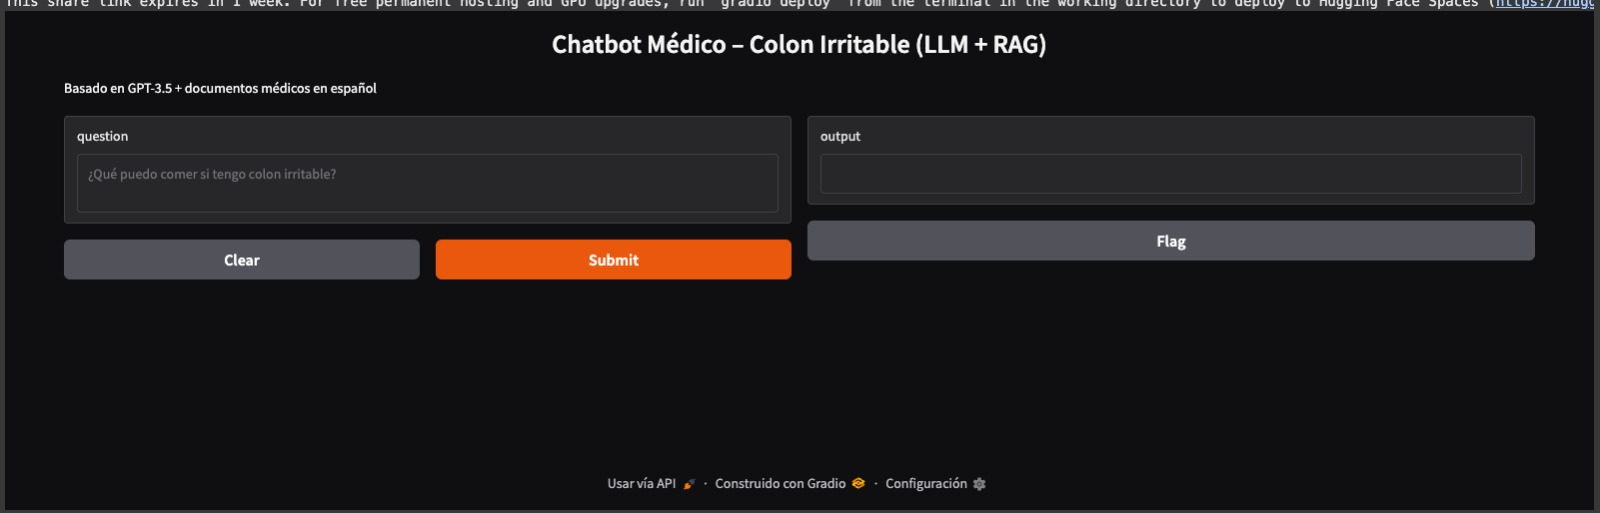

In [ ]:
print("Run Gradio interface...")
launch_gradio(string_rag)

Run Gradio interface...
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://69563be0dae6c3cbcb.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# El chatbot, incluyendo ejemplos de prueba:

A continuación mostramos una serie de preguntas a manera de prueba en donde primeramente se aprecia la pregunta utilizando unicamente el modelo de LLM sin el RAG para posteriormente contrastarlo con el modelo de LLM + RAG.

De esta manera se puede comparar de manera más justa el comportamiento de ambos modelos.

## Pregunta 1:

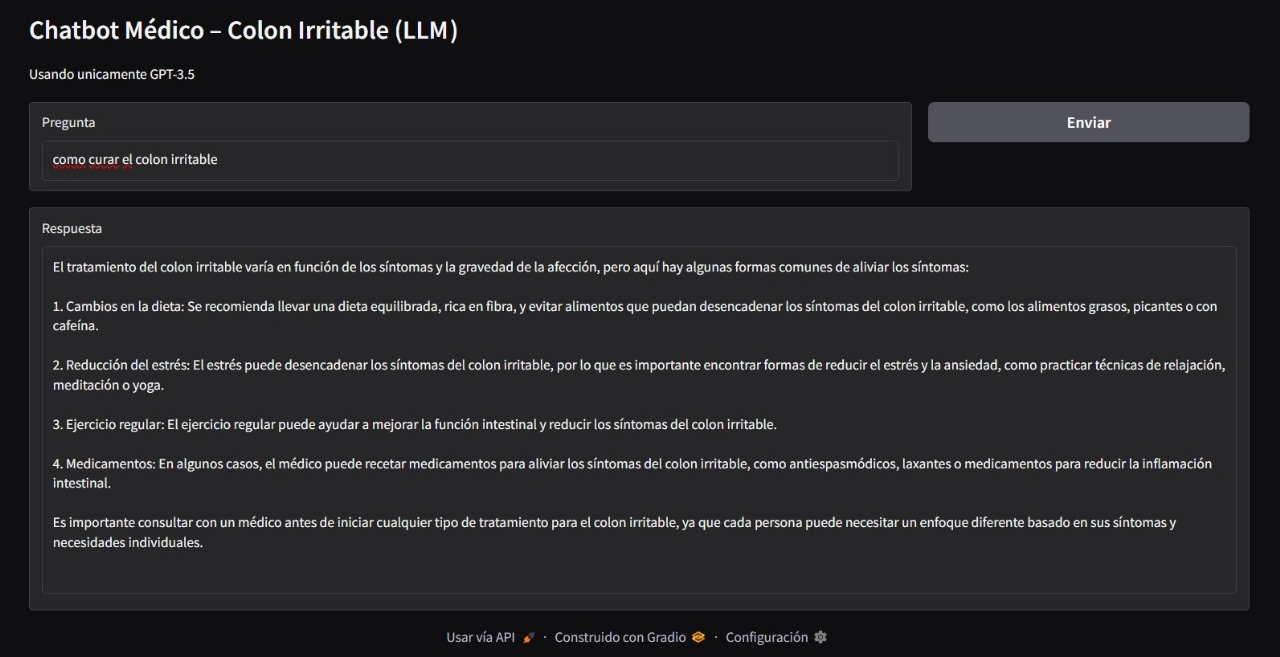

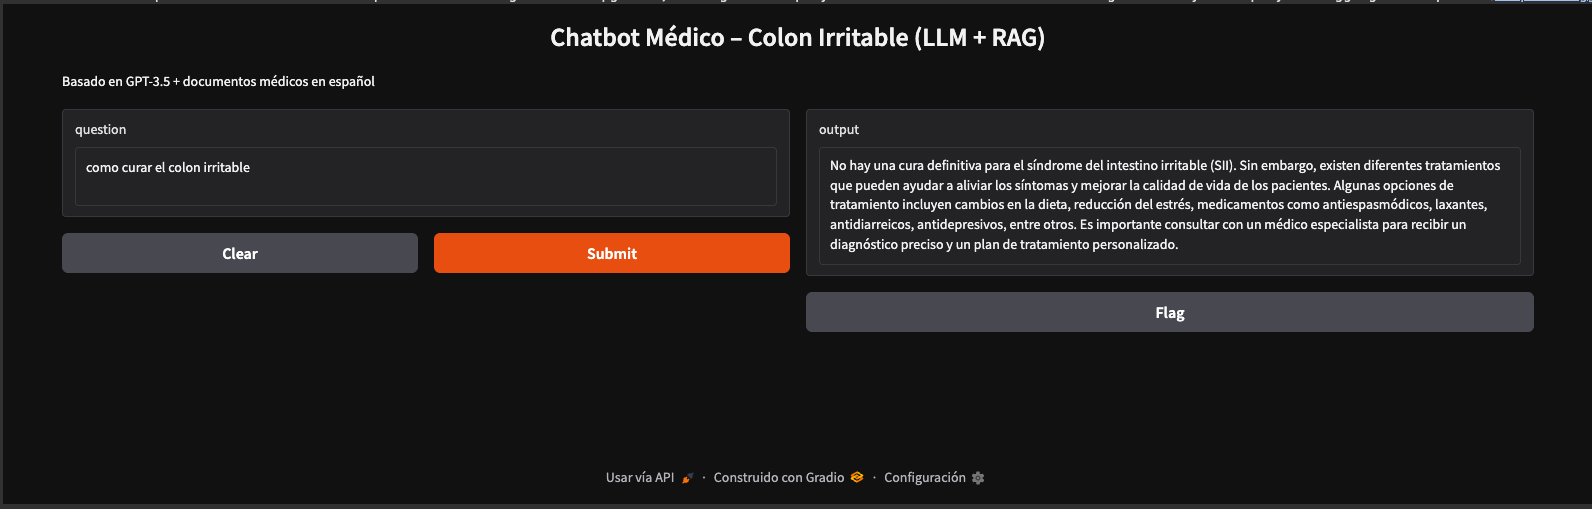

## Pregunta 2:

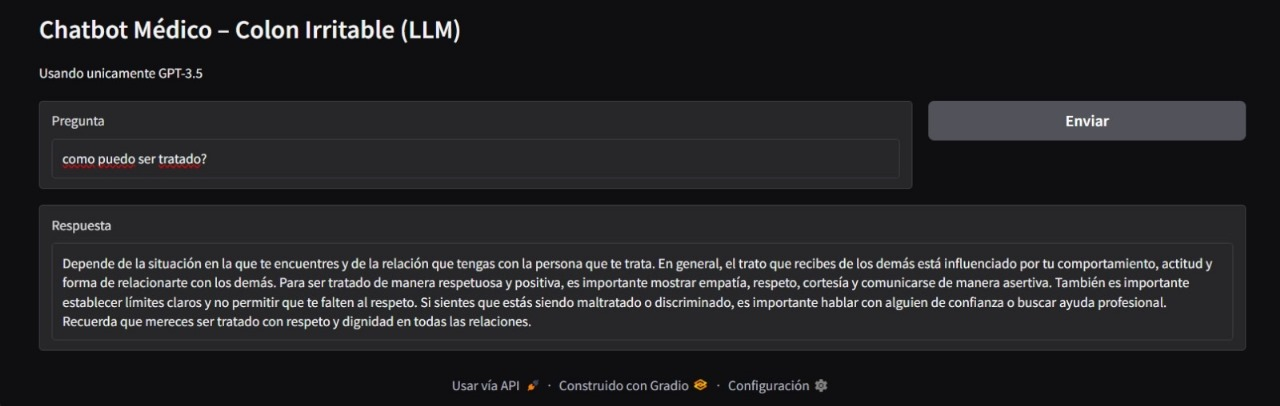

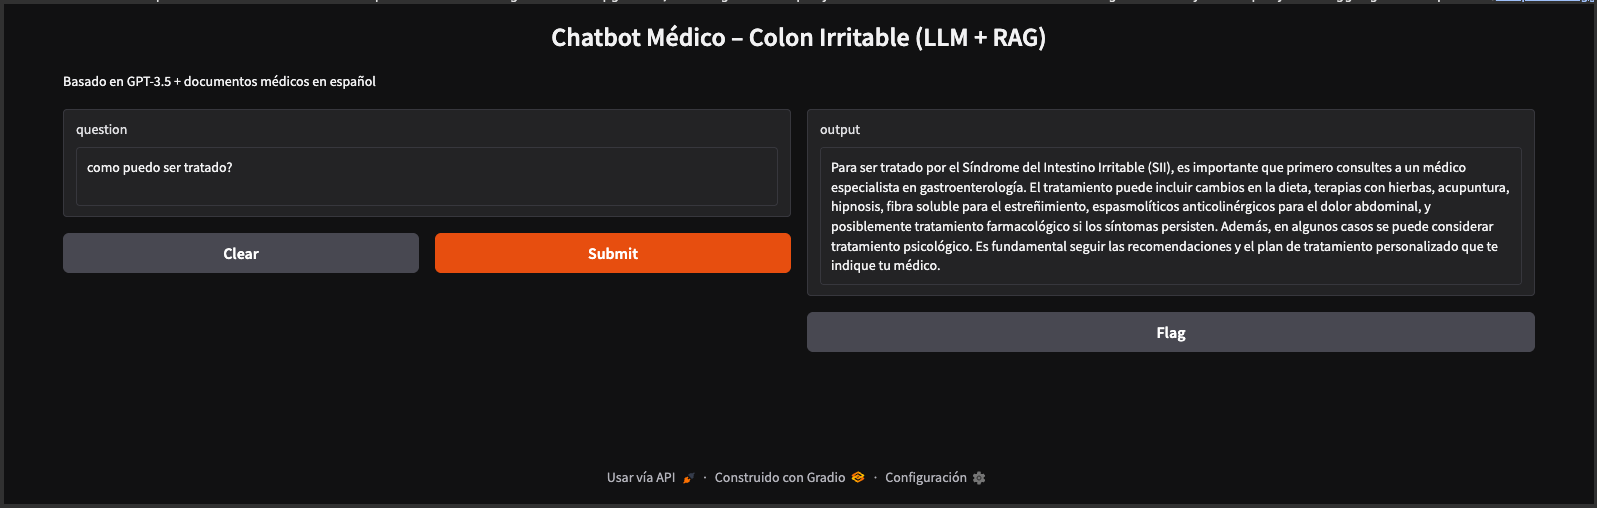

## Pregunta 3:

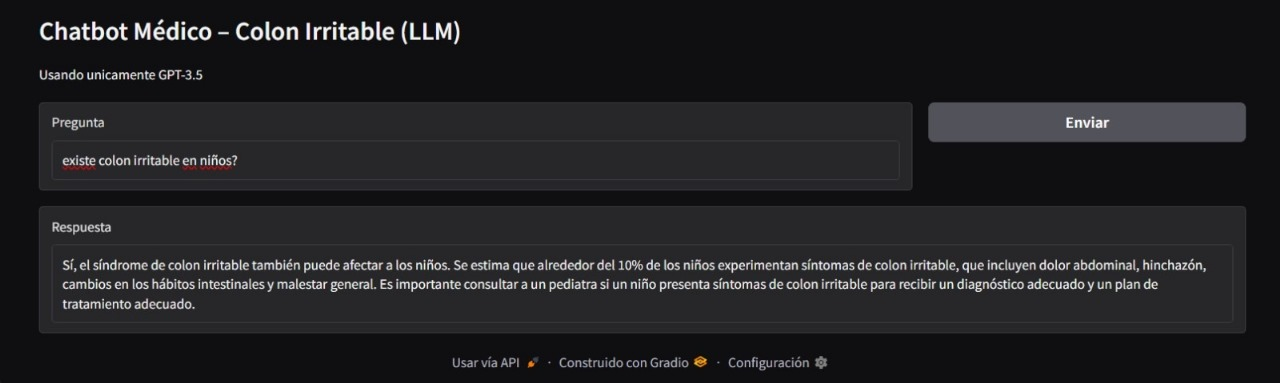

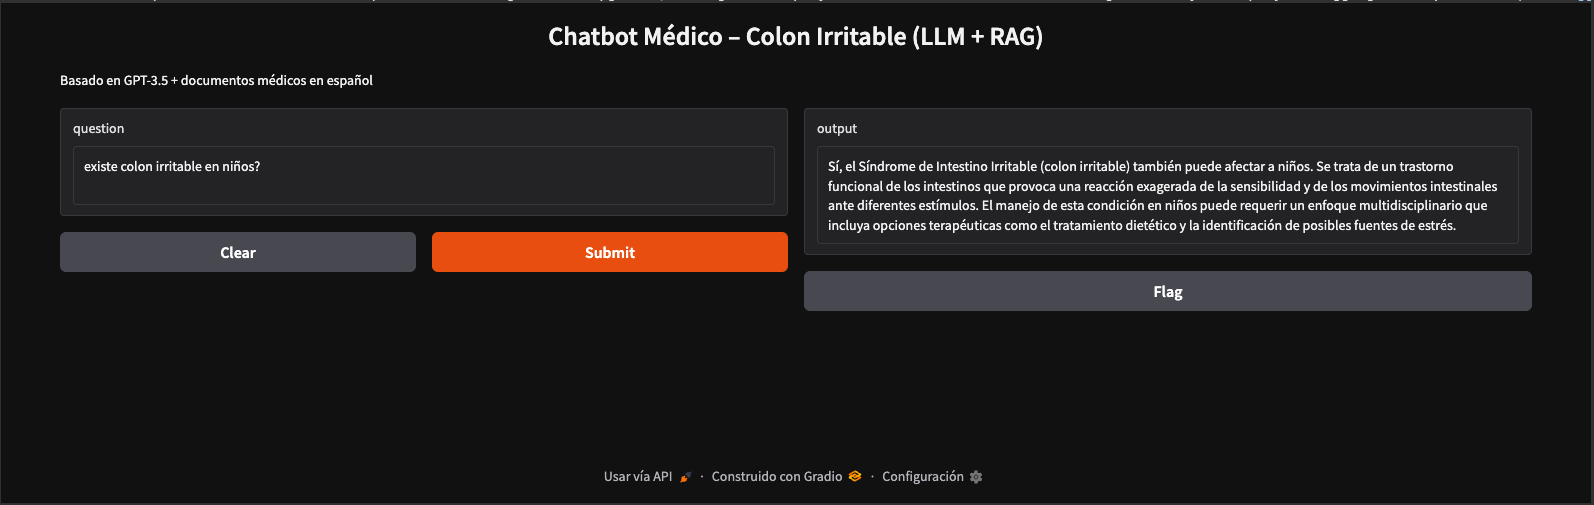

## Pregunta 4:

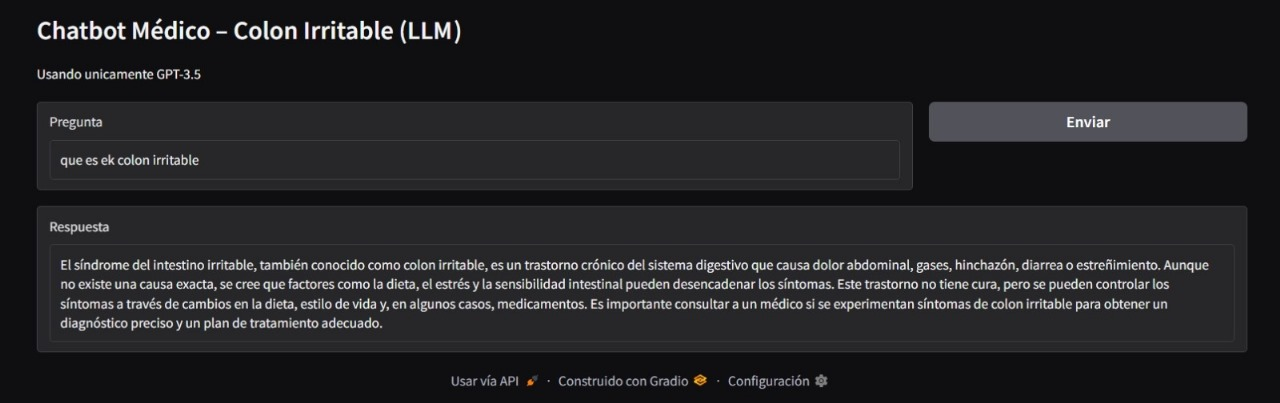

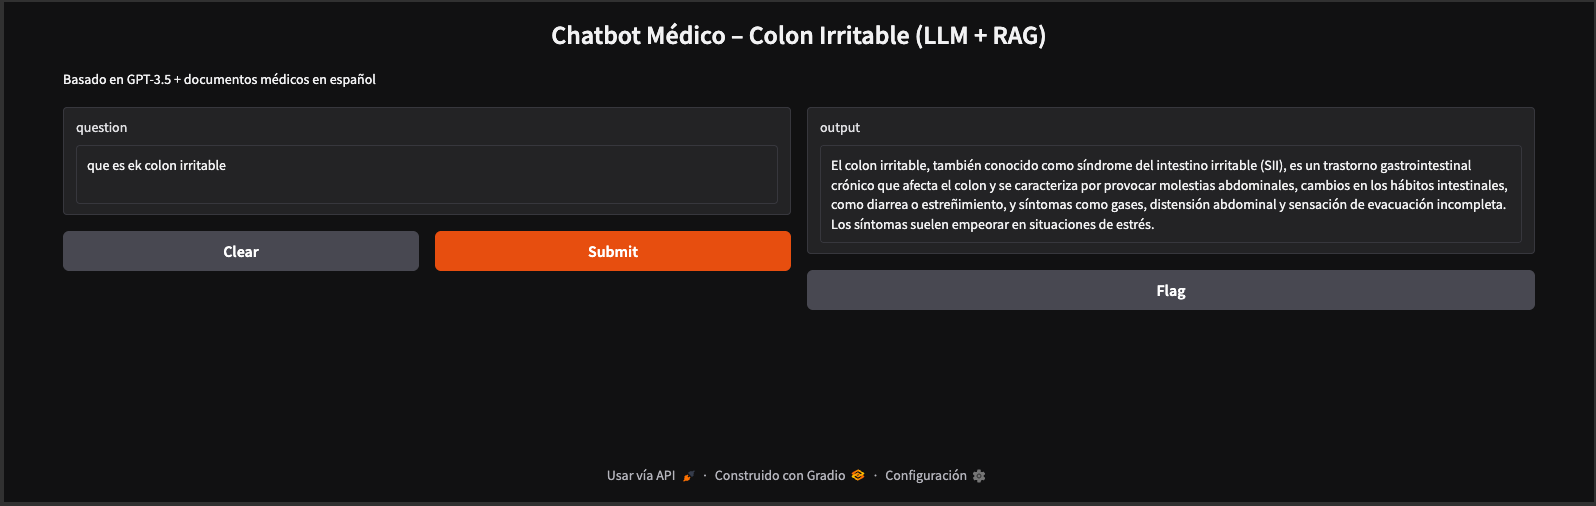

## Pregunta 5:

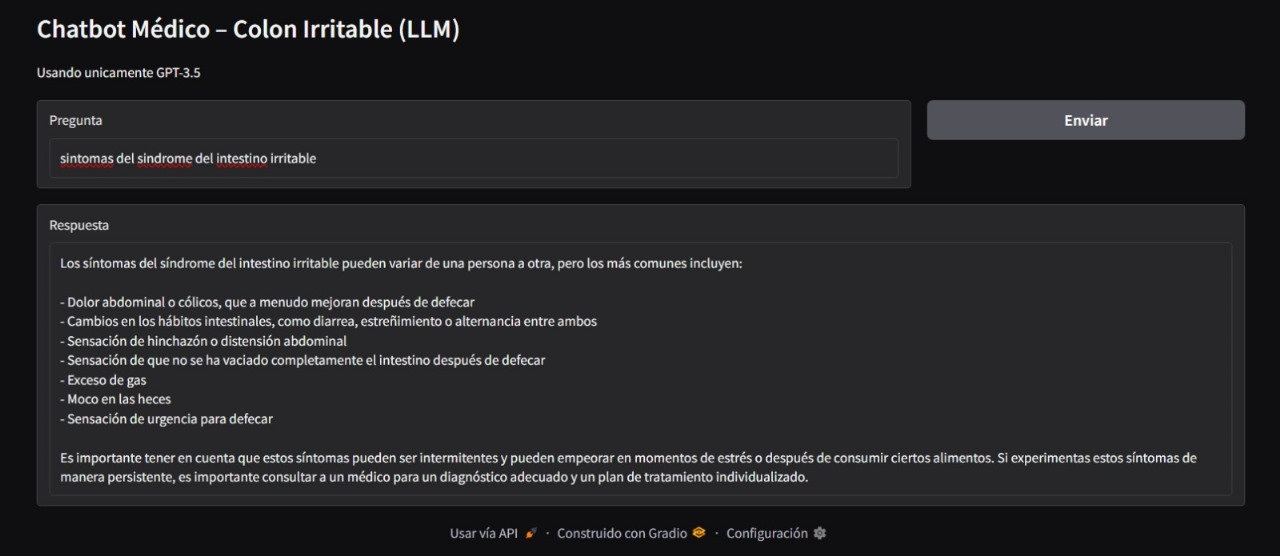

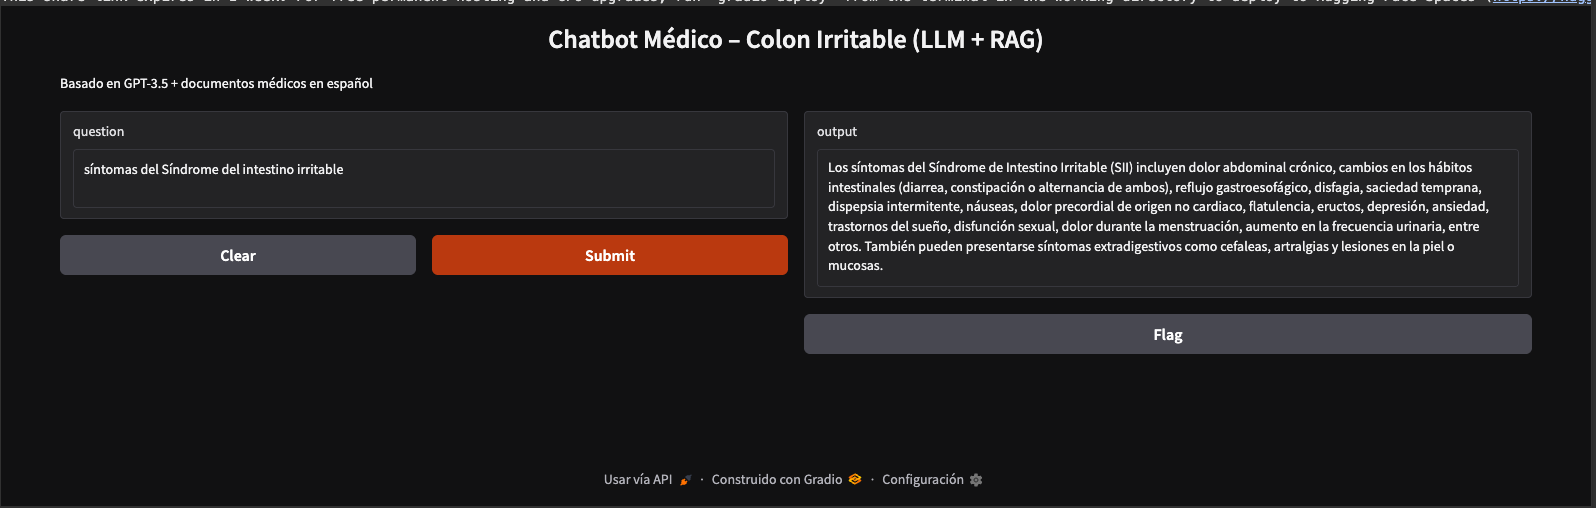

# **Conclusiones:**

La implementación del chatbot médico basado en LLM + RAG nos permitió construir un sistema de consulta especializada sobre el Síndrome del Intestino Irritable (SII) con respuestas personalizadas, coherentes y contextualizadas en español. A partir del uso de documentos médicos indexados (provenientes de fuentes como el IMSS, Cochrane, MedlinePlus y consensos clínicos mexicanos) combinados con el poder del modelos de GPT-3.5 turbo, el sistema fue capaz de ofrecer respuestas informativas con un lenguaje claro, técnico pero accesible.

Durante las pruebas realizadas —como se muestra en las capturas adjuntas—, las respuestas fueron evaluadas según los siguientes criterios:

* **Relevancia clínica:** Las respuestas se alinearon correctamente con la información médica validada. Por ejemplo, al consultar sobre los síntomas del SII, el sistema enumeró signos digestivos y extradigestivos consistentes con la literatura especializada.

* **Adecuación contextual:** Se respetó el enfoque de un público general, manteniendo un tono empático, sin emitir diagnósticos médicos. Además, se reiteró la importancia de la consulta profesional.

* **Adaptación al idioma y cultura:** El sistema respondió en español neutral, usando términos como “estreñimiento”, “plan de tratamiento personalizado” y “consultar al especialista”, basado en el contexto mexicano.

* **Robustez ante diferentes preguntas:** Desde preguntas generales (“¿Qué es el colon irritable?”) hasta específicas (“¿Existe en niños?” o “¿Cómo puede tratarse?”), el sistema demostró solidez y consistencia.

**Como mejora futura,** se podría incluir segmentación de respuestas por perfil (adulto, pediátrico, mujer embarazada) o integración con un sistema de evaluación de confianza de fuentes. También se podría entrenar un modelo embebido en español para mayor precisión semántica.

# Referencias:

*   Instituto Mexicano del Seguro Social. (2015). Diagnóstico y tratamiento del intestino irritable en el adulto (Catálogo Maestro de Guías de Práctica Clínica: IMSS-042-08). Coordinación Técnica de Excelencia Clínica.
García Ron, G., Monzón Bueno, A. I., Merino Villeneuve, I., Ruíz Chércoles, E., Samblás Tilves, P. (2015). Síndrome de intestino irritable. Guías de actuación conjunta Pediatría Primaria-Especializada.
Secretaría de Salud. (2025). Grupo N° 8: Gastroenterología.
Chey, W. D., Eswaran, S., & Kurlander, J. (2015, 3 de marzo). Síndrome de intestino irritable. JAMA, 313(9), 982.
*   The Permanente Medical Group, Inc. (2001). Síndrome del intestino irritable. Kaiser Permanente.
World Gastroenterology Organization. (2015). Síndrome de Intestino Irritable: una Perspectiva Mundial.
Grupo de Trabajo de la Guía de Práctica Clínica sobre el Síndrome del Intestino Irritable. (2005). Síndrome del intestino irritable. Guía de práctica clínica. Asociación Española de Gastroenterología, Sociedad Española de Medicina de Familia y Comunitaria y Centro Cochrane Iberoamericano.

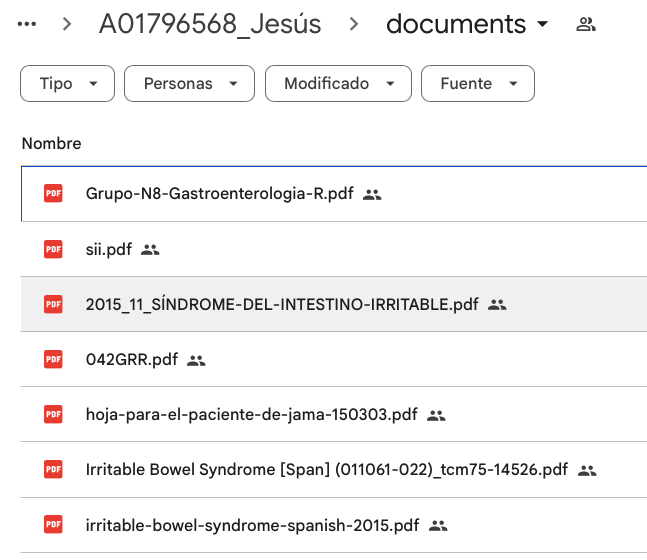

# **Fin de la actividad chatbot: LLM + RAG**